# SME Credit Risk Analysis - Simplified Tutorial

**Goal:** Predict which SME loan applications are likely to become Non-Performing Loans (NPLs)

**What you'll learn:**
- Load and explore data
- Preprocess data for machine learning
- Handle imbalanced classes with SMOTE
- Train 3 different models
- Evaluate and compare model performance

---

## Cell 1: Import Libraries

We need these libraries:
- **pandas**: Data manipulation
- **numpy**: Numerical operations
- **matplotlib/seaborn**: Visualizations
- **sklearn**: Machine learning tools
- **imblearn**: Handle imbalanced data

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Handle imbalanced data
from imblearn.over_sampling import SMOTE

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

# Settings
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = 42  # For reproducibility

print("✓ All libraries imported!")

✓ All libraries imported!


## Cell 2: Load the Dataset

Load the CSV file and take a quick look at what we have.

In [2]:
# Load data
df = pd.read_csv('sme_loan_applications_ghana.csv')

# Basic info
print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumn names:\n{df.columns.tolist()}")

# First few rows
df.head()

Dataset shape: 2500 rows, 29 columns

Column names:
['application_id', 'sector', 'region', 'legal_structure', 'years_in_operation', 'num_employees', 'annual_revenue_ghs', 'total_assets_ghs', 'current_ratio', 'debt_to_equity', 'profit_margin_pct', 'account_age_months', 'avg_monthly_transactions', 'avg_account_balance_ghs', 'previous_loans', 'previous_loan_performance', 'owner_age', 'owner_education', 'credit_bureau_score', 'owner_has_other_businesses', 'loan_amount_requested_ghs', 'loan_to_revenue_ratio', 'loan_purpose', 'loan_term_months', 'collateral_type', 'collateral_coverage_pct', 'interest_rate_pct', 'application_date', 'loan_status']


,application_id,sector,region,legal_structure,years_in_operation,num_employees,annual_revenue_ghs,total_assets_ghs,current_ratio,debt_to_equity,...,owner_has_other_businesses,loan_amount_requested_ghs,loan_to_revenue_ratio,loan_purpose,loan_term_months,collateral_type,collateral_coverage_pct,interest_rate_pct,application_date,loan_status
0,APP000001,Trading,Central,Sole Proprietorship,10,4,136117,165737,1.01,1.16,...,Yes,25927,0.19,Working Capital,24,Vehicle,73.5,29.3,10/29/2025,Performing
1,APP000002,Retail,Eastern,Partnership,5,2,204138,242364,0.30,0.90,...,Yes,26469,0.13,Expansion,12,NaN,0.0,21.4,9/15/2024,Performing
2,APP000003,Construction,Ashanti,Limited Liability,7,10,773041,752973,0.32,0.35,...,Yes,56324,0.07,Working Capital,24,Property,114.4,28.7,5/21/2025,Performing
3,APP000004,Services,Upper East,Sole Proprietorship,5,2,378307,261090,0.63,0.57,...,No,31458,0.08,Equipment Purchase,24,Property,101.1,30.8,5/30/2025,Performing
4,APP000005,Agriculture,Greater Accra,Limited Liability,7,2,292595,415500,0.67,3.83,...,Yes,11305,0.04,Inventory,36,Equipment,74.0,24.2,7/21/2024,Performing


## Cell 3: Understand the Target Variable

Our target is `loan_status` - we want to predict if a loan will be "Performing" or "Non-Performing".

Loan Status Distribution:
loan_status
Performing        2000
Non-Performing     500
Name: count, dtype: int64

NPL Rate: 20.00%


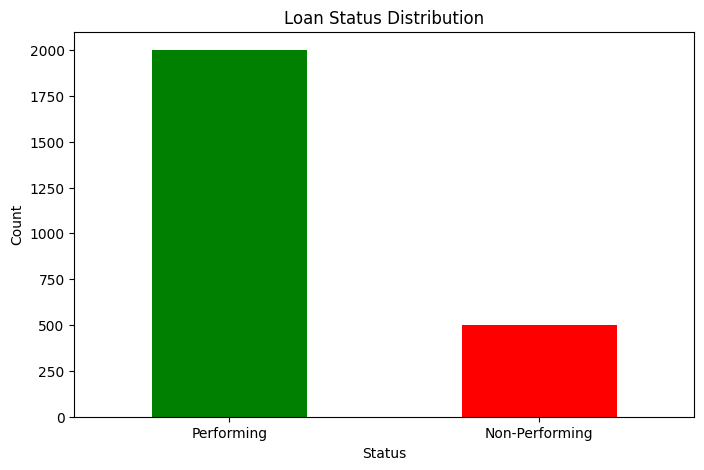

In [3]:
# Count of each class
print("Loan Status Distribution:")
print(df['loan_status'].value_counts())

# Calculate NPL rate
npl_rate = (df['loan_status'] == 'Non-Performing').mean() * 100
print(f"\nNPL Rate: {npl_rate:.2f}%")

# Visualize
plt.figure(figsize=(8, 5))
df['loan_status'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Loan Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Cell 4: Check Data Quality

Look for missing values and data types.

In [4]:
# Data types
print("Data Types:")
print(df.dtypes)

# Missing values
print("\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values!")
else:
    print(missing[missing > 0])

Data Types:
application_id                    str
sector                            str
region                            str
legal_structure                   str
years_in_operation              int64
num_employees                   int64
annual_revenue_ghs              int64
total_assets_ghs                int64
current_ratio                 float64
debt_to_equity                float64
profit_margin_pct             float64
account_age_months              int64
avg_monthly_transactions        int64
avg_account_balance_ghs         int64
previous_loans                  int64
previous_loan_performance         str
owner_age                       int64
owner_education                   str
credit_bureau_score             int64
owner_has_other_businesses        str
loan_amount_requested_ghs       int64
loan_to_revenue_ratio         float64
loan_purpose                      str
loan_term_months                int64
collateral_type                   str
collateral_coverage_pct       float64


## Cell 5: Basic Statistics

Get summary statistics for numerical columns.

In [5]:
# Summary statistics
df.describe()

,years_in_operation,num_employees,annual_revenue_ghs,total_assets_ghs,current_ratio,debt_to_equity,profit_margin_pct,account_age_months,avg_monthly_transactions,avg_account_balance_ghs,previous_loans,owner_age,credit_bureau_score,loan_amount_requested_ghs,loan_to_revenue_ratio,loan_term_months,collateral_coverage_pct,interest_rate_pct
count,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000
mean,5.585600,11.391600,3.462658e+05,3.680935e+05,1.214940,1.577300,7.52896,23.662000,73.201600,34981.454400,0.808400,41.816800,620.660400,93909.062000,1.056900,27.564000,78.26976,24.177640
std,3.437586,15.182386,5.486476e+05,6.283759e+05,0.823006,1.069839,11.94684,12.230731,33.123753,60957.213397,0.884535,10.920208,83.799582,100267.197223,2.217412,12.707198,47.25273,3.749135
min,0.000000,1.000000,1.500000e+04,9.144000e+03,0.300000,0.000000,-25.00000,3.000000,7.000000,606.000000,0.000000,25.000000,338.000000,10000.000000,0.000000,12.000000,0.00000,18.000000
25%,3.000000,3.000000,7.440825e+04,7.650400e+04,0.570000,0.770000,-1.10000,15.000000,49.000000,6702.000000,0.000000,34.000000,565.000000,30504.500000,0.120000,18.000000,26.20000,21.300000
50%,5.000000,7.000000,1.656855e+05,1.697355e+05,1.010000,1.350000,7.50000,22.000000,69.000000,15342.000000,1.000000,41.000000,622.000000,60062.500000,0.370000,24.000000,86.05000,24.100000
75%,7.000000,14.000000,3.781092e+05,3.887080e+05,1.640000,2.120000,15.90000,31.000000,92.000000,37152.750000,1.000000,49.000000,675.000000,117822.750000,0.980000,36.000000,116.55000,26.800000
max,27.000000,216.000000,5.000000e+06,7.338127e+06,4.000000,5.000000,40.00000,77.000000,239.000000,793626.000000,5.000000,75.000000,850.000000,500000.000000,33.330000,60.000000,149.90000,35.000000


## Cell 6: Identify Feature Types

Separate numerical and categorical features.

In [6]:
# Find numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Find categorical columns  
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove non-predictive columns
non_predictive = ['application_id', 'application_date', 'loan_status']
numerical_cols = [col for col in numerical_cols if col not in non_predictive]
categorical_cols = [col for col in categorical_cols if col not in non_predictive]

print(f"Numerical features ({len(numerical_cols)}):")
print(numerical_cols)

print(f"\nCategorical features ({len(categorical_cols)}):")
print(categorical_cols)

Numerical features (18):
['years_in_operation', 'num_employees', 'annual_revenue_ghs', 'total_assets_ghs', 'current_ratio', 'debt_to_equity', 'profit_margin_pct', 'account_age_months', 'avg_monthly_transactions', 'avg_account_balance_ghs', 'previous_loans', 'owner_age', 'credit_bureau_score', 'loan_amount_requested_ghs', 'loan_to_revenue_ratio', 'loan_term_months', 'collateral_coverage_pct', 'interest_rate_pct']

Categorical features (8):
['sector', 'region', 'legal_structure', 'previous_loan_performance', 'owner_education', 'owner_has_other_businesses', 'loan_purpose', 'collateral_type']


## Cell 7: EDA - Distribution of Key Numerical Features

Visualize how key features are distributed.

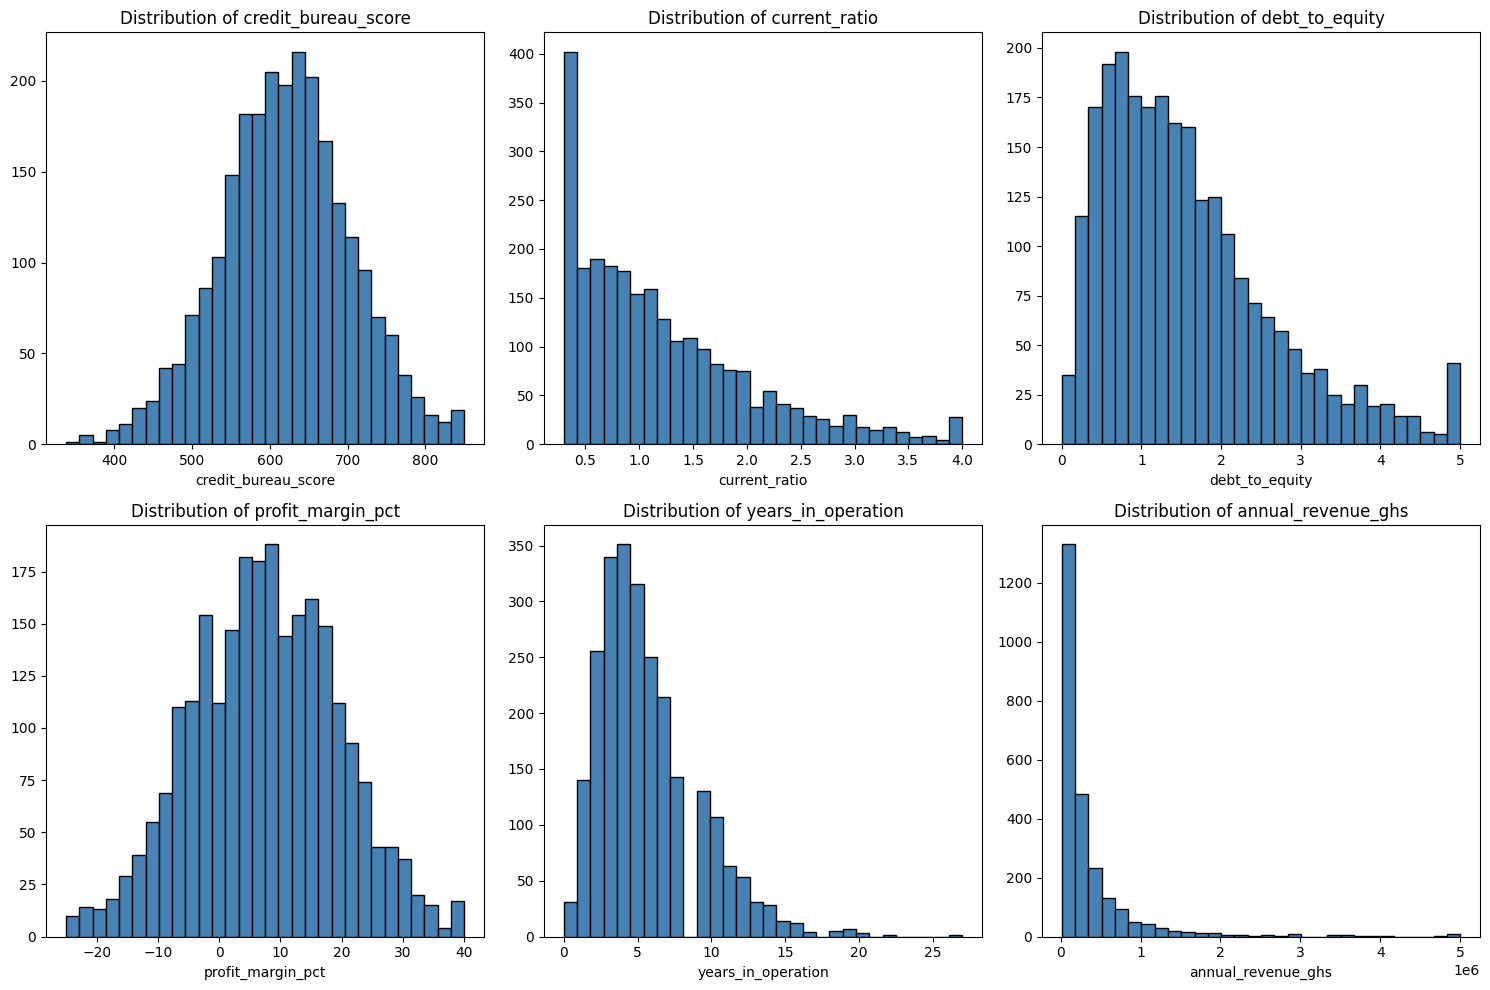

In [7]:
# Key features to visualize
key_features = ['credit_bureau_score', 'current_ratio', 'debt_to_equity', 
                'profit_margin_pct', 'years_in_operation', 'annual_revenue_ghs']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(key_features):
    if col in df.columns:
        axes[i].hist(df[col], bins=30, color='steelblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

## Cell 8: EDA - Compare Features by Loan Status

See how features differ between Performing and Non-Performing loans.

In [8]:
# Compare key metrics
performing = df[df['loan_status'] == 'Performing']
non_performing = df[df['loan_status'] == 'Non-Performing']

# Credit score comparison
print("Credit Bureau Score:")
print(f"  Performing loans average: {performing['credit_bureau_score'].mean():.0f}")
print(f"  Non-Performing loans average: {non_performing['credit_bureau_score'].mean():.0f}")

# Current ratio comparison
print("\nCurrent Ratio:")
print(f"  Performing loans average: {performing['current_ratio'].mean():.2f}")
print(f"  Non-Performing loans average: {non_performing['current_ratio'].mean():.2f}")

# Debt-to-equity comparison
print("\nDebt-to-Equity:")
print(f"  Performing loans average: {performing['debt_to_equity'].mean():.2f}")
print(f"  Non-Performing loans average: {non_performing['debt_to_equity'].mean():.2f}")

Credit Bureau Score:
  Performing loans average: 634
  Non-Performing loans average: 566

Current Ratio:
  Performing loans average: 1.25
  Non-Performing loans average: 1.07

Debt-to-Equity:
  Performing loans average: 1.53
  Non-Performing loans average: 1.78


## Cell 9: EDA - NPL Rate by Sector

Which business sectors have the highest NPL rates?

NPL Rate by Sector:
sector
Hospitality      24.870466
Agriculture      23.958333
Construction     23.706897
Retail           23.684211
Services         20.802005
Trading          18.390805
Manufacturing    15.570934
Transport        15.476190
Healthcare       14.545455
Technology        6.976744
Name: loan_status, dtype: float64


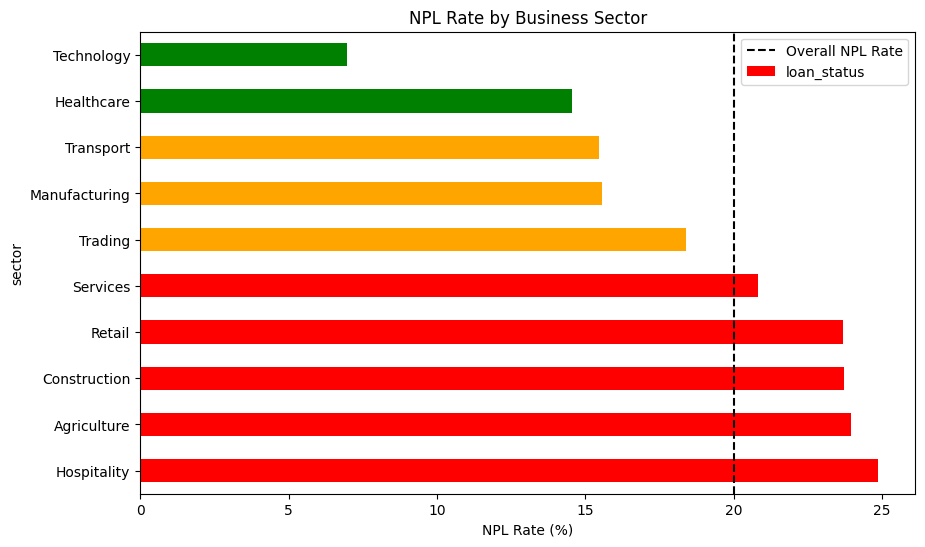

In [9]:
# Calculate NPL rate by sector
npl_by_sector = df.groupby('sector')['loan_status'].apply(
    lambda x: (x == 'Non-Performing').mean() * 100
).sort_values(ascending=False)

print("NPL Rate by Sector:")
print(npl_by_sector)

# Visualize
plt.figure(figsize=(10, 6))
colors = ['red' if x > 20 else 'orange' if x > 15 else 'green' for x in npl_by_sector]
npl_by_sector.plot(kind='barh', color=colors)
plt.xlabel('NPL Rate (%)')
plt.title('NPL Rate by Business Sector')
plt.axvline(x=20, color='black', linestyle='--', label='Overall NPL Rate')
plt.legend()
plt.show()

## Cell 10: Correlation Heatmap

Check which features are correlated with each other.

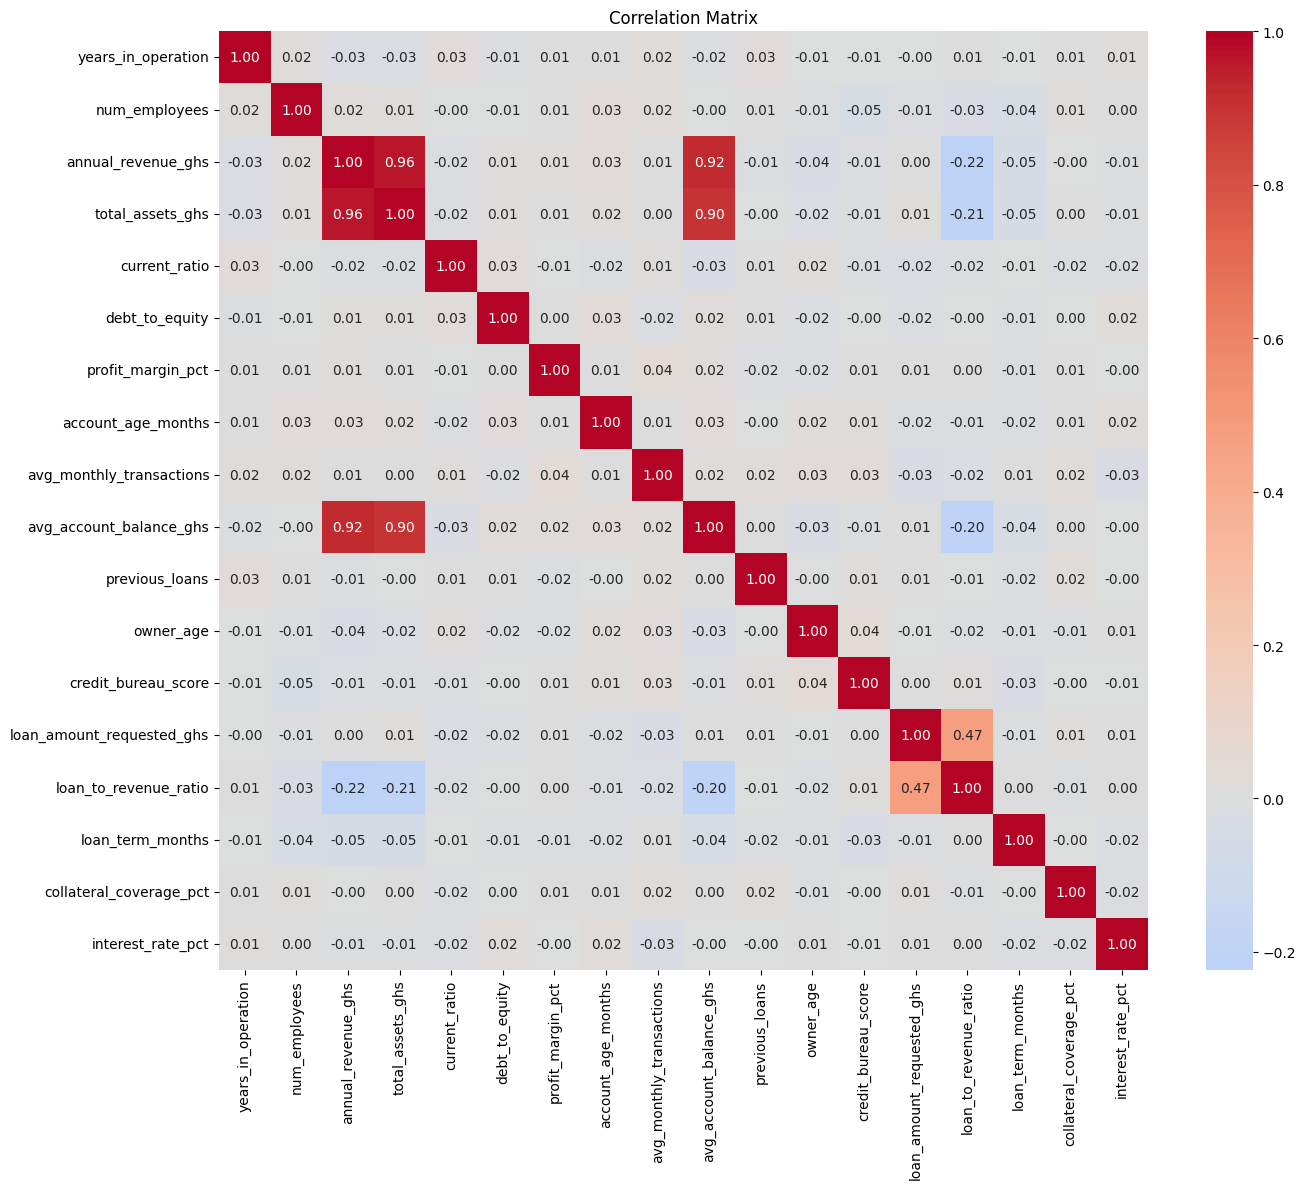

In [10]:
# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

---
# DATA PREPROCESSING
---

## Cell 11: Prepare Features and Target

- Drop non-predictive columns (ID, date)
- Separate features (X) and target (y)
- Convert target to binary (0/1)

In [11]:
# Make a copy for modeling
df_model = df.copy()

# Drop non-predictive columns
df_model = df_model.drop(['application_id', 'application_date'], axis=1)

# Separate features (X) and target (y)
X = df_model.drop('loan_status', axis=1)
y = df_model['loan_status']

# Convert target: Performing=0, Non-Performing=1
y = y.map({'Performing': 0, 'Non-Performing': 1})

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(f"  0 (Performing): {(y == 0).sum()}")
print(f"  1 (Non-Performing): {(y == 1).sum()}")

Features shape: (2500, 26)
Target shape: (2500,)

Target distribution:
  0 (Performing): 2000
  1 (Non-Performing): 500


## Cell 12: Encode Categorical Variables

Machine learning models need numbers, not text. We'll:
- Use **Label Encoding** for binary categories (Yes/No)
- Use **One-Hot Encoding** for categories with multiple values

In [12]:
# Find categorical columns in X
cat_columns = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {cat_columns}")

# Label encode binary columns (like Yes/No)
binary_cols = ['owner_has_other_businesses']  # Add other binary columns here
label_encoders = {}

for col in binary_cols:
    if col in cat_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
        print(f"  ✓ Label encoded: {col}")

# One-hot encode remaining categorical columns
remaining_cat = [col for col in cat_columns if col not in binary_cols]
X_encoded = pd.get_dummies(X, columns=remaining_cat, drop_first=True)

print(f"\nShape after encoding: {X_encoded.shape}")

Categorical columns to encode: ['sector', 'region', 'legal_structure', 'previous_loan_performance', 'owner_education', 'owner_has_other_businesses', 'loan_purpose', 'collateral_type']
  ✓ Label encoded: owner_has_other_businesses

Shape after encoding: (2500, 57)


## Cell 13: Train-Test Split

Split data: 80% for training, 20% for testing.

**Important:** Use `stratify=y` to keep the same NPL rate in both sets.

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y,
    test_size=0.20,           # 20% for testing
    random_state=RANDOM_SEED,  # For reproducibility
    stratify=y                 # Keep same class distribution
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining NPL rate: {y_train.mean() * 100:.2f}%")
print(f"Test NPL rate: {y_test.mean() * 100:.2f}%")

Training set: 2000 samples
Test set: 500 samples

Training NPL rate: 20.00%
Test NPL rate: 20.00%


## Cell 14: Scale Features

Standardize features to have mean=0 and std=1. This helps many ML algorithms perform better.

**Important:** Fit scaler on training data only, then transform both train and test.

In [14]:
# Create scaler
scaler = StandardScaler()

# Fit on training data, transform both
X_train_scaled = scaler.fit_transform(X_train)  # fit + transform
X_test_scaled = scaler.transform(X_test)        # only transform

# Convert back to DataFrame (optional but helpful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features scaled")
print(f"Training set mean: {X_train_scaled.mean().mean():.4f} (should be ~0)")
print(f"Training set std: {X_train_scaled.std().mean():.4f} (should be ~1)")

✓ Features scaled
Training set mean: 0.0000 (should be ~0)
Training set std: 1.0003 (should be ~1)


## Cell 15: Handle Class Imbalance with SMOTE

Our data is imbalanced (more Performing than Non-Performing loans). 

**SMOTE** (Synthetic Minority Over-sampling Technique) creates synthetic examples of the minority class.

In [15]:
# Before SMOTE
print("BEFORE SMOTE:")
print(f"  Class 0 (Performing): {(y_train == 0).sum()}")
print(f"  Class 1 (Non-Performing): {(y_train == 1).sum()}")

# Apply SMOTE (only on training data!)
smote = SMOTE(random_state=RANDOM_SEED, sampling_strategy=0.5)  # Minority = 50% of majority
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# After SMOTE
print("\nAFTER SMOTE:")
print(f"  Class 0 (Performing): {(y_train_balanced == 0).sum()}")
print(f"  Class 1 (Non-Performing): {(y_train_balanced == 1).sum()}")
print(f"\n✓ Training set now has {len(y_train_balanced)} samples")

BEFORE SMOTE:
  Class 0 (Performing): 1600
  Class 1 (Non-Performing): 400

AFTER SMOTE:
  Class 0 (Performing): 1600
  Class 1 (Non-Performing): 800

✓ Training set now has 2400 samples


---
# MODEL TRAINING
---

## Cell 16: Train Logistic Regression

A simple, interpretable model. Great for understanding feature importance.

In [16]:
# Create model
lr_model = LogisticRegression(
    random_state=RANDOM_SEED,
    max_iter=1000,
    class_weight='balanced'
)

# Train model
lr_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1

print("✓ Logistic Regression trained!")

✓ Logistic Regression trained!


## Cell 17: Train Support Vector Machine (SVM)

A powerful model that finds the best boundary between classes.

In [17]:
# Create model
svm_model = SVC(
    random_state=RANDOM_SEED,
    kernel='rbf',
    class_weight='balanced',
    probability=True  # Needed for predict_proba
)

# Train model
svm_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

print("✓ SVM trained!")

✓ SVM trained!


## Cell 18: Train Naive Bayes

A fast, probabilistic model that assumes feature independence.

In [18]:
# Create model
nb_model = GaussianNB()

# Train model
nb_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_nb = nb_model.predict(X_test_scaled)
y_prob_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

print("✓ Naive Bayes trained!")

✓ Naive Bayes trained!


---
# MODEL EVALUATION
---

## Cell 19: Create Evaluation Function

A helper function to calculate all metrics for a model.

In [19]:
def evaluate_model(y_true, y_pred, y_prob, model_name):
    """
    Calculate all evaluation metrics for a model.
    
    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels (0 or 1)
    - y_prob: Predicted probabilities
    - model_name: Name of the model (for display)
    
    Returns:
    - Dictionary with all metrics
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Print results
    print(f"\n{'='*50}")
    print(f"MODEL: {model_name}")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

## Cell 20: Evaluate All Models

Calculate metrics for each model and store results.

In [20]:
# Evaluate each model
results = {}

results['Logistic Regression'] = evaluate_model(y_test, y_pred_lr, y_prob_lr, 'Logistic Regression')
results['SVM'] = evaluate_model(y_test, y_pred_svm, y_prob_svm, 'SVM')
results['Naive Bayes'] = evaluate_model(y_test, y_pred_nb, y_prob_nb, 'Naive Bayes')


MODEL: Logistic Regression
Accuracy:  0.8460
Precision: 0.5762
Recall:    0.8700
F1-Score:  0.6932
ROC-AUC:   0.9217

MODEL: SVM
Accuracy:  0.8420
Precision: 0.5897
Recall:    0.6900
F1-Score:  0.6359
ROC-AUC:   0.8934

MODEL: Naive Bayes
Accuracy:  0.7260
Precision: 0.3865
Recall:    0.6300
F1-Score:  0.4791
ROC-AUC:   0.7651


## Cell 21: Understanding the Confusion Matrix

The confusion matrix shows:
- **True Negatives (TN)**: Correctly predicted Performing loans
- **False Positives (FP)**: Performing loans wrongly flagged as NPL
- **False Negatives (FN)**: NPLs we missed (costly!)
- **True Positives (TP)**: Correctly predicted NPLs

In [21]:
# Show confusion matrix for best model (Logistic Regression usually)
cm = results['Logistic Regression']['confusion_matrix']
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (Logistic Regression):")
print(f"\n                 Predicted")
print(f"               0         1")
print(f"Actual  0   {tn:4d}     {fp:4d}   (Performing)")
print(f"        1   {fn:4d}     {tp:4d}   (Non-Performing)")

print(f"\n\nInterpretation:")
print(f"  ✓ Correctly identified {tp} out of {tp+fn} NPLs ({tp/(tp+fn)*100:.1f}%)")
print(f"  ✗ Missed {fn} NPLs (False Negatives)")
print(f"  ✗ False alarms: {fp} (Good loans flagged as risky)")

Confusion Matrix (Logistic Regression):

                 Predicted
               0         1
Actual  0    336       64   (Performing)
        1     13       87   (Non-Performing)


Interpretation:
  ✓ Correctly identified 87 out of 100 NPLs (87.0%)
  ✗ Missed 13 NPLs (False Negatives)
  ✗ False alarms: 64 (Good loans flagged as risky)


## Cell 22: Compare Models Visually

Model Comparison:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression     0.846   0.576159    0.87  0.693227  0.92170
                SVM     0.842   0.589744    0.69  0.635945  0.89345
        Naive Bayes     0.726   0.386503    0.63  0.479087  0.76515


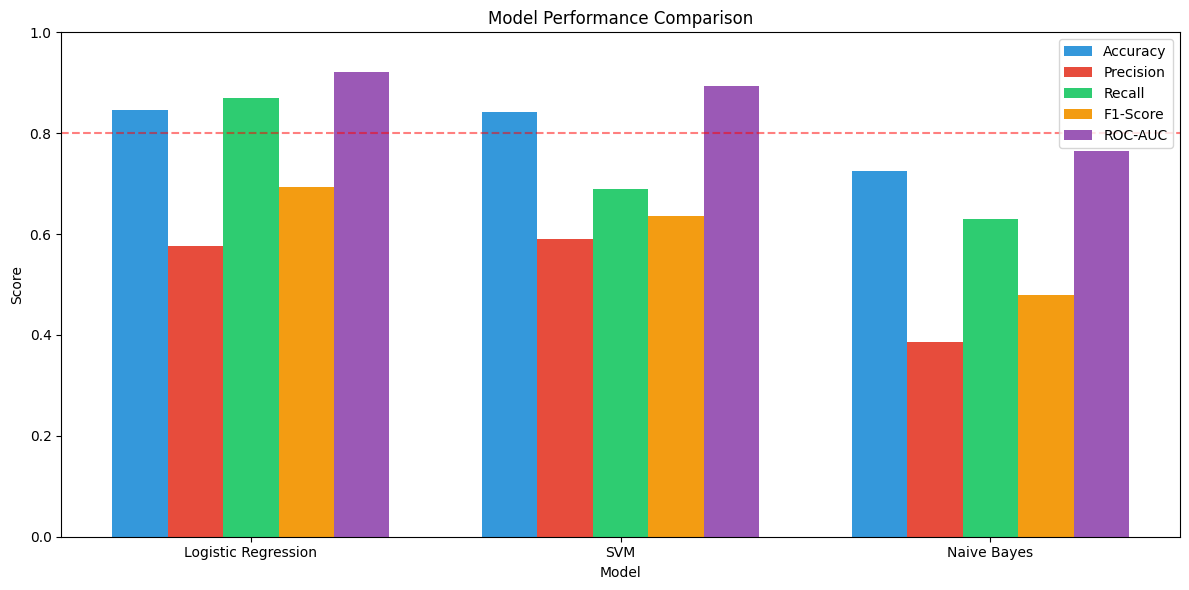

In [22]:
# Create comparison DataFrame
comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results]
})

print("Model Comparison:")
print(comparison.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison))
width = 0.15

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, comparison[metric], width, label=metric, color=colors[i])

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.set_ylim(0, 1)
ax.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Target')
plt.tight_layout()
plt.show()

## Cell 23: Plot ROC Curves

ROC curve shows the trade-off between True Positive Rate and False Positive Rate.

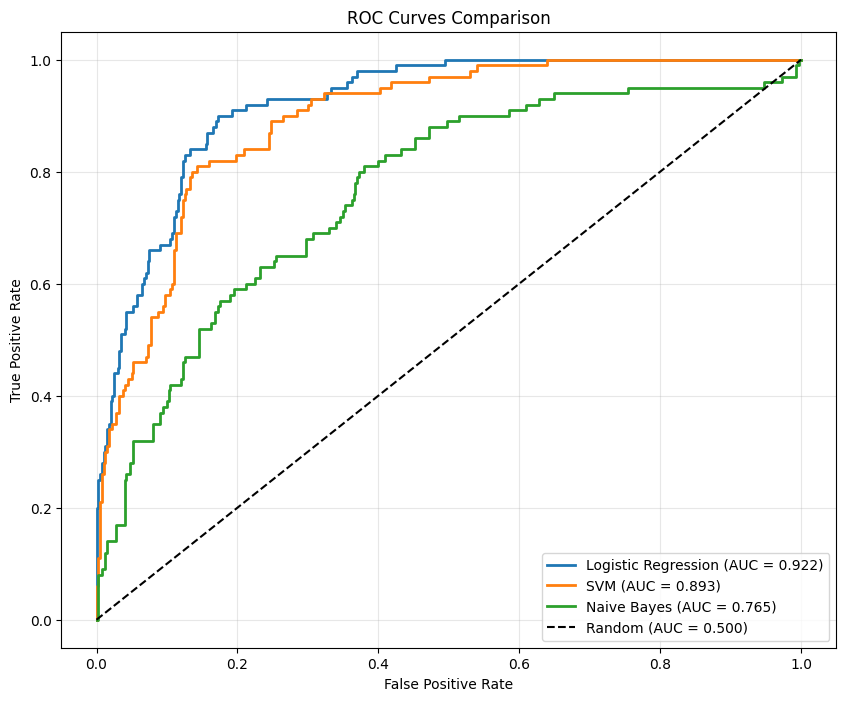

In [23]:
plt.figure(figsize=(10, 8))

# Plot ROC for each model
models_data = [
    ('Logistic Regression', y_prob_lr),
    ('SVM', y_prob_svm),
    ('Naive Bayes', y_prob_nb)
]

for name, y_prob in models_data:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = results[name]['roc_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## Cell 24: Feature Importance (Logistic Regression)

See which features have the biggest impact on predictions.

Top 15 Most Important Features:
                             Feature  Coefficient
                 credit_bureau_score    -1.812853
previous_loan_performance_No History     1.237412
                   profit_margin_pct    -1.233986
             collateral_coverage_pct    -1.138917
      previous_loan_performance_Fair     1.012552
      previous_loan_performance_Poor     0.968910
                  years_in_operation    -0.690866
                  account_age_months    -0.671646
                  annual_revenue_ghs    -0.628752
                       current_ratio    -0.614149
                      debt_to_equity     0.503587
                   sector_Technology    -0.503411
             owner_education_Primary     0.462048
           owner_education_Secondary     0.439809
           loan_amount_requested_ghs     0.373005


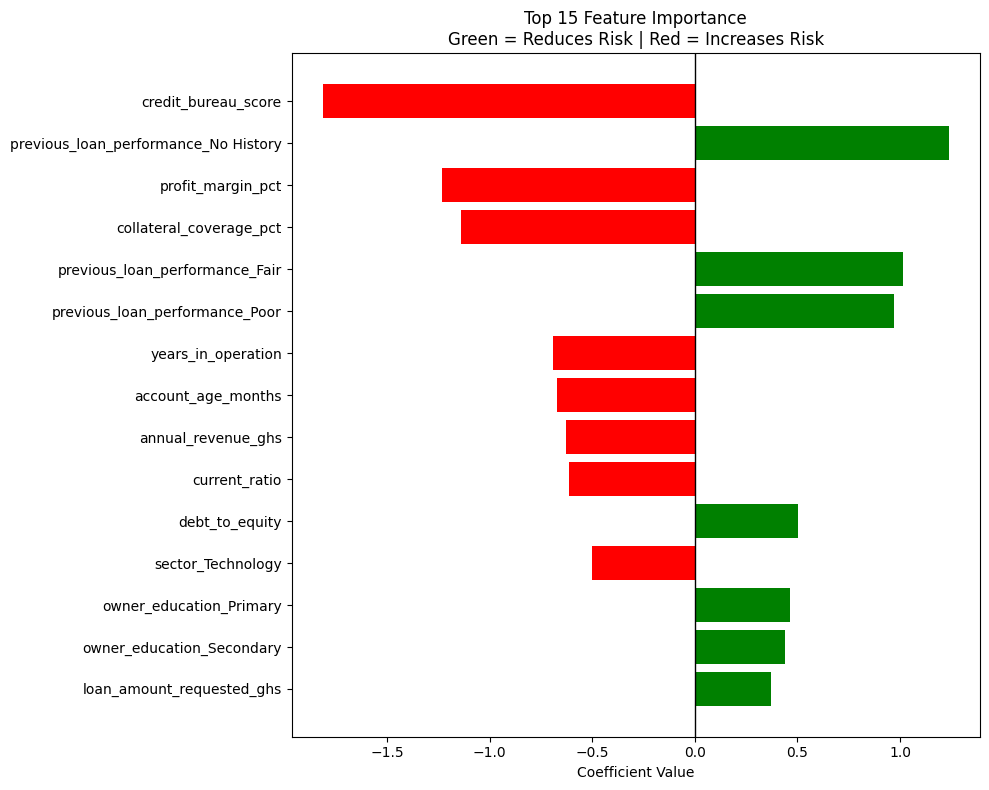

In [24]:
# Get feature importance from coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lr_model.coef_[0]
})

# Sort by absolute value
feature_importance['Abs_Coef'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coef', ascending=False)

# Top 15 features
top_15 = feature_importance.head(15)

print("Top 15 Most Important Features:")
print(top_15[['Feature', 'Coefficient']].to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in top_15['Coefficient']]
plt.barh(range(len(top_15)), top_15['Coefficient'], color=colors)
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Importance\nGreen = Reduces Risk | Red = Increases Risk')
plt.axvline(x=0, color='black', linewidth=1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Cell 25: Select Champion Model

Choose the best model based on ROC-AUC score.

In [25]:
# Find best model
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_metrics = results[best_model_name]

print("="*50)
print("🏆 CHAMPION MODEL")
print("="*50)
print(f"\nModel: {best_model_name}")
print(f"\nPerformance:")
print(f"  ROC-AUC:   {best_metrics['roc_auc']:.4f}")
print(f"  Accuracy:  {best_metrics['accuracy']:.4f}")
print(f"  Recall:    {best_metrics['recall']:.4f}")
print(f"  Precision: {best_metrics['precision']:.4f}")
print(f"  F1-Score:  {best_metrics['f1']:.4f}")

🏆 CHAMPION MODEL

Model: Logistic Regression

Performance:
  ROC-AUC:   0.9217
  Accuracy:  0.8460
  Recall:    0.8700
  Precision: 0.5762
  F1-Score:  0.6932


## Cell 26: Save the Model (Optional)

Save the trained model for future use.

In [26]:
import joblib
from datetime import datetime

# Package everything needed for deployment
model_package = {
    'model': lr_model,  # The trained model
    'scaler': scaler,   # The feature scaler
    'features': list(X_train_scaled.columns),  # Feature names
    'label_encoders': label_encoders,  # For categorical encoding
    'metrics': results['Logistic Regression'],
    'trained_date': datetime.now().strftime('%Y-%m-%d')
}

# Save to file
joblib.dump(model_package, 'sme_credit_risk_model.pkl')
print("✓ Model saved as 'sme_credit_risk_model.pkl'")

✓ Model saved as 'sme_credit_risk_model.pkl'


---
# SUMMARY
---

## Cell 27: Final Summary

In [27]:
print("="*60)
print("SME CREDIT RISK ANALYSIS - SUMMARY")
print("="*60)

print(f"\n📊 DATASET")
print(f"   Total records: {len(df)}")
print(f"   Features: {X_encoded.shape[1]}")
print(f"   NPL Rate: {(df['loan_status'] == 'Non-Performing').mean() * 100:.2f}%")

print(f"\n🔧 PREPROCESSING")
print(f"   Train/Test split: 80/20")
print(f"   Class balancing: SMOTE")
print(f"   Feature scaling: StandardScaler")

print(f"\n🤖 MODELS TRAINED")
print(f"   1. Logistic Regression")
print(f"   2. Support Vector Machine")
print(f"   3. Naive Bayes")

print(f"\n🏆 CHAMPION MODEL: {best_model_name}")
print(f"   ROC-AUC: {best_metrics['roc_auc']:.4f}")
print(f"   Recall: {best_metrics['recall']:.4f}")

print(f"\n✅ ANALYSIS COMPLETE!")

SME CREDIT RISK ANALYSIS - SUMMARY

📊 DATASET
   Total records: 2500
   Features: 57
   NPL Rate: 20.00%

🔧 PREPROCESSING
   Train/Test split: 80/20
   Class balancing: SMOTE
   Feature scaling: StandardScaler

🤖 MODELS TRAINED
   1. Logistic Regression
   2. Support Vector Machine
   3. Naive Bayes

🏆 CHAMPION MODEL: Logistic Regression
   ROC-AUC: 0.9217
   Recall: 0.8700

✅ ANALYSIS COMPLETE!


---
## Key Concepts Recap

| Concept | What it means | Why it matters |
|---------|--------------|----------------|
| **SMOTE** | Creates synthetic minority samples | Helps model learn from imbalanced data |
| **Stratified Split** | Keeps class ratio in train/test | Ensures fair evaluation |
| **StandardScaler** | Makes features mean=0, std=1 | Many algorithms work better with scaled data |
| **ROC-AUC** | Area under ROC curve | Best metric for imbalanced classification |
| **Recall** | % of actual positives found | Critical when missing positives is costly |
| **Precision** | % of predicted positives correct | Important when false positives are costly |

---